# Algorithm Walk-Through

This notebook will walkthrough the preprocessing steps as well as the ML algorithm training procedure used for the multi-dimensional, multi-output data. 

## Experiment Overview

## Code

### Packages

In [74]:
import sys
sys.path.insert(0, "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/src")

# Standard packages
import numpy as np
import pandas as pd

# Datasets
from data.make_dataset import DataLoader, load_standard_data, load_high_dim_data, load_labels

# Features
from features.build_features import times_2_cycles, geo_2_cartesian, get_geodataframe, CycleTransform, GeoCartTransform
from features.pca_features import transform_all, transform_individual
from features.analysis import get_stats
from sklearn.preprocessing import StandardScaler

# ML Models
from sklearn.model_selection import train_test_split
from models.baseline import train_rf_model

# Visualization
from visualization.visualize import plot_mo_stats, plot_geolocations
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### 1 Load Data

#### 1.1 Core Data

In this step, we will load the standard data. This includes the following variables:

* SLA
* PAR
* RHO WN 412
* RHO WN 443
* RHO WN 490
* RHO WN 555
* RHO WN 670
* MLD
* Lat
* Lon
* DOY

In [75]:
params = {
    'region': 'na',
    'n_components': 5,
    'pca_seed': 123
}

dataloader = DataLoader()

# load training data
X_core = load_standard_data(params['region'], training=True)

# Testing Data
X_core_te = load_standard_data(params['region'], training=False)
X_core_te = X_core_te.iloc[:, 2:]

##### Plot Training Data

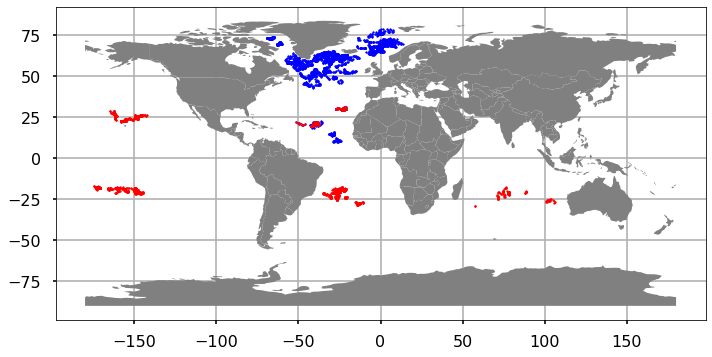

In [76]:
X_core_na = load_standard_data('NA', training=True)
X_core_stg = load_standard_data('STG', training=True)

# convert dataframe into geopandas dataframe
X_core_na_gdf = get_geodataframe(X_core_na.copy())
X_core_na_stg = get_geodataframe(X_core_stg.copy())

# plot world map with points
colors = ['blue', 'red']
plot_geolocations([X_core_na_gdf, X_core_na_stg], colors=['blue', 'red'], save_name='both')

##### Plot Testing Regions

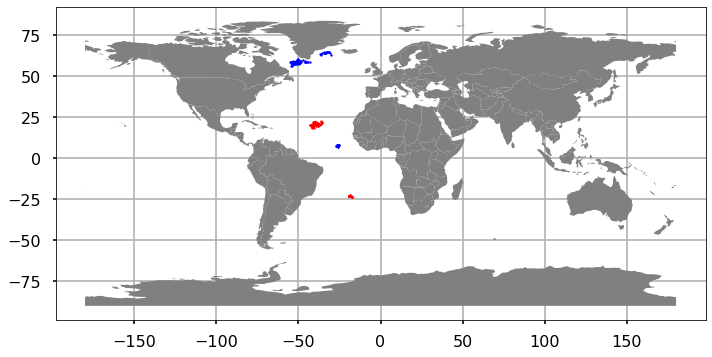

In [77]:
X_core_na = load_standard_data('NA', training=False)
X_core_stg = load_standard_data('STG', training=False)

# convert dataframe into geopandas dataframe
X_core_na_gdf = get_geodataframe(X_core_na.copy())
X_core_na_stg = get_geodataframe(X_core_stg.copy())

# plot world map with points
colors = ['blue', 'red']
plot_geolocations([X_core_na_gdf, X_core_na_stg], colors=['blue', 'red'], save_name='both')

#### 1.2 High Dimensional Data

In this section, we will extract the high dimensional datasets. They include:

* Temperature
* Density
* Salinity
* Spiciness

In [78]:
# ===================
# Training Data
# ===================
# load data from dataloader
X_temp, X_dens, X_sal, X_spicy = load_high_dim_data(
    params['region'], training=True
)

# add prefix (Training/Validation)
X_temp = X_temp.add_prefix("temp_")
X_dens = X_dens.add_prefix("dens_")
X_sal = X_sal.add_prefix("sal_")
X_spicy = X_spicy.add_prefix("spice_")

# ===================
# Test Data
# ===================
# load data from dataloader
X_temp_te, X_dens_te, X_sal_te, X_spicy_te = load_high_dim_data(
    params['region'], training=False
)

# Subset meta columns
X_temp_te = X_temp_te.iloc[:, 2:]
X_dens_te = X_dens_te.iloc[:, 2:]
X_sal_te = X_sal_te.iloc[:, 2:]
X_spicy_te = X_spicy_te.iloc[:, 2:]

# add prefix (Test)
X_temp_te = X_temp_te.add_prefix("temp_")
X_dens_te = X_dens_te.add_prefix("dens_")
X_sal_te = X_sal_te.add_prefix("sal_")
X_spicy_te = X_spicy_te.add_prefix("spice_")

#### 1.3 - Concatenate Data

In [79]:
# Concatenate Data
# Training Data
Xtr = pd.concat([X_core, X_temp, X_dens, X_sal, X_spicy], axis=1)

# Testing Data
Xte = pd.concat([X_core_te, X_temp_te, X_dens_te, X_sal_te, X_spicy_te], axis=1)

#### 1.4 - Multi-Output Data

We load the multioutput regression labels.

In [80]:
# ===================
# Labels
# ===================
ytr = load_labels(params['region'], training=True)

ytest = load_labels(params['region'], training=False)

# remove meta-columns
ytest = ytest.iloc[:, 2:]

---
### 4 - Post-Split Transformations



1. PCA Transform High Dimensional Variables

In this step, we do a PCA transformation on the concatenation for the high dimensional variables `temp`, `sal`, `dens`, and `spicy`. We will reduce the dimensionality to about 10 features.

2. Normalize Core Variables

We will use a standard scaler to make the core variables with a mean of 0 and standard deviation of 1. The ML algorithms tend to perform better with this type of standardization.

3. Coordinate Transformation

In this step, we will do a simple coordinate transformation of the lat,lon variables from geospatial to cartesian coordinates. This will increase the dimensionality of our dataset from 11 dimensions to 12 dimensions.

4. Time Transformation

In this step, we will transform the `doy` coordinates to cycles of sines and cosines. This will increase the dimensionality of our data from from 12 to 13.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

#### 4.1 - Input Preprocessing

In [82]:
# new columns columns
dataloader = DataLoader()

columns = dataloader.load_columns()


n_components = 5
times = ['doy']

# create new columns
new_columns = [
    *["doy_cos", "doy_sin"], 
    *['x', 'y', 'z',],
    *[f"temperature_pc{icomponent+1}" for icomponent in range(params['n_components'])],
    *[f"density_pc{icomponent+1}" for icomponent in range(params['n_components'])],
    *[f"salinity_pc{icomponent+1}" for icomponent in range(params['n_components'])],
    *[f"spicy_pc{icomponent+1}" for icomponent in range(params['n_components'])],
    *columns["core"], 
]
seed = 123

# define transfomer
X_pre_transformer = ColumnTransformer(
    [
        ("time", CycleTransform(columns["time"]), columns["time"]),
        ("location", GeoCartTransform(), columns["location"]),
        (
            "temperature",
            PCA(n_components=params['n_components'], random_state=params['pca_seed']),
            columns["temperature"],
        ),
        (
            "density",
            PCA(n_components=params['n_components'], random_state=params['pca_seed']),
            columns["density"],
        ),
        (
            "salinity",
            PCA(n_components=params['n_components'], random_state=params['pca_seed']),
            columns["salinity"],
        ),
        (
            "spicy",
            PCA(n_components=params['n_components'], random_state=params['pca_seed']),
            columns["spicy"],
        ),
        (
            "core",
            StandardScaler(with_mean=True, with_std=True),
            columns["core"],
        ),
    ],
    remainder="passthrough",
)


In [83]:
# transform data
X_pre_transformer.fit(Xtr)

# transform data
Xtr = X_pre_transformer.transform(Xtr)
Xte = X_pre_transformer.transform(Xte)

##### Plot PCA Components

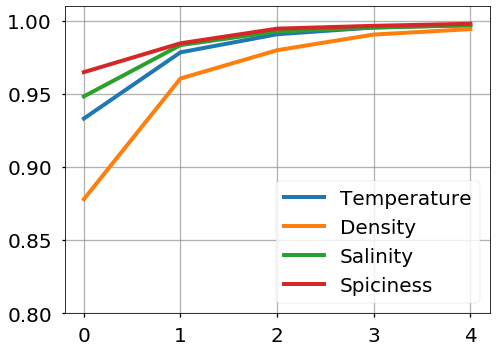

In [84]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'na'
# y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(X_pre_transformer.named_transformers_['temperature'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Temperature')
plt.plot(X_pre_transformer.named_transformers_['density'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Density')
plt.plot(X_pre_transformer.named_transformers_['salinity'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Salinity')
plt.plot(X_pre_transformer.named_transformers_['spicy'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Spiciness')
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
ax.set_ylim([0.8, 1.01])
plt.legend(fontsize=20, loc='lower right')
plt.tight_layout()
plt.show()
# fig.savefig(SAVE_PATH + f"evar_{save_name}.png")

---
### 3 - Train,Test Split

We split the data into 80% training and 20% training.

**Note**: because the dataset we are dealing with is only ~3,000 data points, we will do some bootstrap techniques in the full experiment to see how well we do with different subsamples of data.

In [85]:
# train-test split
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(
        Xtr, ytr,
        train_size=0.8, random_state=123
    )

### 4 - Post Output Transformations

The distribution of the outputs are skewed because there is a lot more variability in the upper depths than the lower depths. Because the distribution of the outputs are fairly skewed, we propose to do a log transformation to make them normally distributed. We do the following:

1. Do a log10 transformation
2. Standardize the Outputs

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Inverse log10 function
def loginv(x): return 10 ** x

# create pipeline
y_transformer = Pipeline([
    # Log10 transformer
    ("log", FunctionTransformer(func=np.log10, inverse_func=loginv)),
    # Standardize the outputs (helps with NN models)
    ("scale", StandardScaler(with_mean=True, with_std=True))
])

# transform data
ytrain = y_transformer.fit_transform(ytrain)
yvalid = y_transformer.transform(yvalid)
ytest = y_transformer.fit_transform(ytest)

---
### 5 - Train ML Model

In this section, we will use a standard random forest (RF) regressor to train on our dataset.

In [64]:
def save_model(model, save_name):
    # model path
    MODEL_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/models/control/"
    
    # save model
    from joblib import dump
    dump(model, MODEL_PATH + save_name + '.joblib')
    return None

In [65]:
model_name = 'morf'

# RF params
rf_params = {
    "n_estimators": 1_500,
    "criterion": "mse",
    "n_jobs": -1,
    "random_state": 123,
    "warm_start": False,
    "verbose": 1,
}

# train model
model = train_rf_model(Xtrain, ytrain, params=rf_params)

# save model
save_model(model, f"{model_name}_na")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   36.7s finished


Training time: 37.415 secs.


---
### 6 - Test ML Model

#### 6.1 - Training Data Results

This is often not reported but it is very good to check how well a model does on the initial training data because we have no entered a validation set. If we find that the training stats are too high and the testing stats are very low then we know that we're either overfitting and/or our model is not generalizing very well.

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_stats(y_pred: np.ndarray, y: np.ndarray, each_level: bool=False):
    
    stats = pd.DataFrame()
    
    # Get total average statistics
    if each_level == False:
        multioutput = 'uniform_average'
        mae = mean_absolute_error(y, ypred, multioutput=multioutput)
        mse = mean_squared_error(y, ypred, multioutput=multioutput)
        rmse = mse
        r2 = r2_score(y, ypred, multioutput=multioutput)
        stats = pd.DataFrame(data=[[mae, mse, rmse, r2]], columns=['mae', 'mse', 'rmse', 'r2'])
    elif each_level == True:
        multioutput = 'raw_values'
        stats['mae'] = mean_absolute_error(y, ypred, multioutput=multioutput)
        stats['mse'] = mean_squared_error(y, ypred, multioutput=multioutput)
        stats['rmse'] = np.sqrt(stats['mse'])
        stats['r2'] = r2_score(y, ypred, multioutput=multioutput)
    else:
        raise ValueError(f"Unrecognized stat request: {each_level}")
    
    return stats

First we will look at the statistics on average to see what we get.

In [67]:
ypred = model.predict(Xtrain)

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.8s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    1.5s
[Parallel(n_jobs=28)]: Done 1194 tasks      | elapsed:    2.2s
[Parallel(n_jobs=28)]: Done 1500 out of 1500 | elapsed:    2.7s finished


(-5.863397779903146, 13.594780012746048)

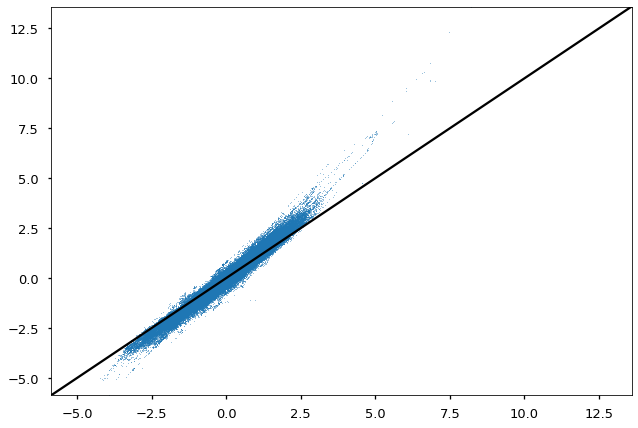

In [69]:
min_lim = np.min(np.concatenate((ypred, ytrain)))
max_lim = np.max(np.concatenate((ypred, ytrain)))


plt.scatter(ypred, ytrain, s=0.1)
plt.plot(np.linspace(min_lim, max_lim), np.linspace(min_lim, max_lim), color='black', zorder=3)
plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])

Then we can look at the statistics for each level.

In [71]:
import statsmodels.api as smi


stat_mod = smi.OLS(ypred.ravel(), ytrain.ravel())

res = stat_mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          2.292e+07
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        12:54:17   Log-Likelihood:                      3.1462e+05
No. Observations:              631488   AIC:                                 -6.292e+05
Df Residuals:                  631487   BIC:                                 -6.292e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

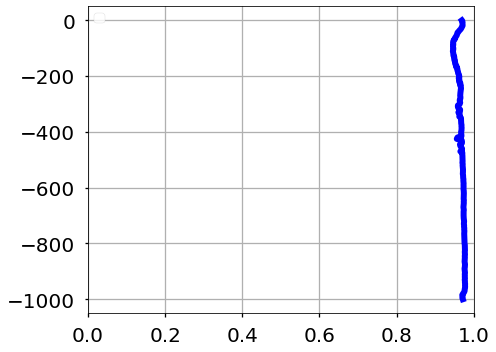

In [72]:
statistic = 'r2'

stats_df = get_stats(ypred, ytrain, each_level=True)

plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat=statistic, 
    save_name='na_train'
)

#### 6.2 - Testing Data Results

In [92]:
ypred = model.predict(Xvalid)

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.5s
[Parallel(n_jobs=28)]: Done 1194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=28)]: Done 1500 out of 1500 | elapsed:    0.9s finished


In [93]:
# each level
each_level = False

stats = get_stats(ypred, yvalid, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.350488,0.269311,0.269311,0.73119


In [95]:
each_level = True

stats_df = get_stats(ypred, yvalid, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.342811,0.226361,0.475774,0.784954
1,0.334066,0.221741,0.470894,0.789384
2,0.340962,0.227880,0.477368,0.784288
3,0.336849,0.223797,0.473071,0.787629
4,0.330158,0.219167,0.468153,0.788237


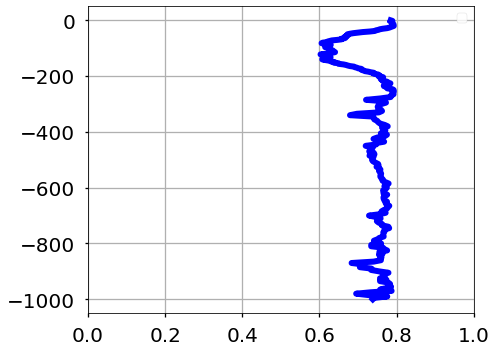

In [96]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat='r2', 
    save_name='na_test'
)


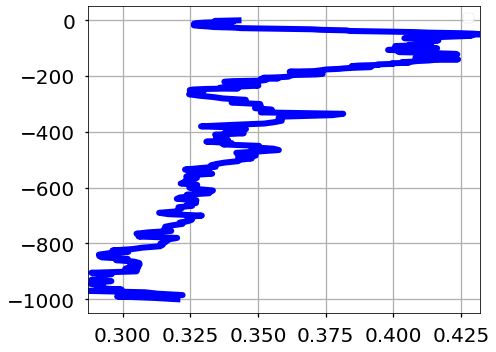

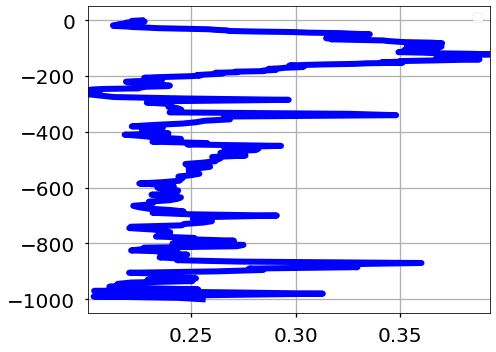

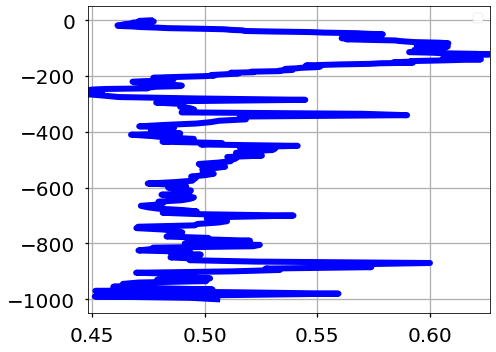

In [97]:
plot_mo_stats(stats_df, stat='mae', save_name='na_test')
plot_mo_stats(stats_df, stat='mse', save_name='na_test')
plot_mo_stats(stats_df, stat='rmse', save_name='na_test')

---
### 7 - Post Analysis

#### 7.1 - Feature Importance

For some algorithms, we can calculate the feature importance based on the inputs dimensions. This is true for the random forest model.

In [135]:
rf_model.

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [99]:
tree_feature_importances = \
    model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

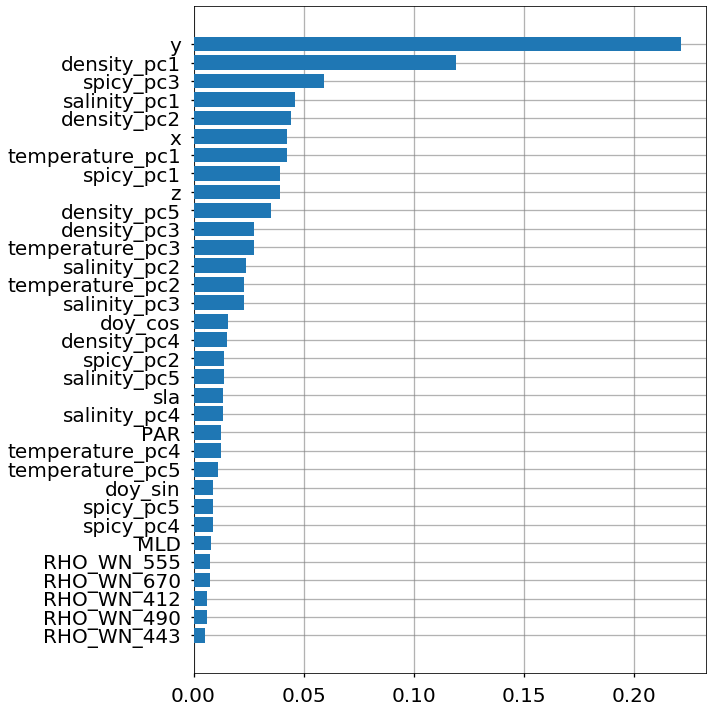

In [100]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'na'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
# fig.savefig(SAVE_PATH + f"fi_{save_name}.png")